#Transfer learning to create AloisNet CNN

AloisNet is CNN model able to detect 4 levels of Alzheimer dementia of a patient "Very midl demented", "Mild Demented", "Moderated Demented" and "Non Demented". So "AloisNet" constant with 4 output neurons. 

The present notebook was created by two students:

* Daniel José Centeno González
* Arnoldo Javier Trujillo Robelo

From "La Salle Technological University", León, Nicaragua.

In this notebook you can found all the process that we did to train "AloisNet"

In [ ]:
#Import all the libreries used
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from keras.metrics import categorical_crossentropy
from keras.layers.core import Dense, Activation
from tensorflow.keras.models import Sequential
from keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam 
from keras.preprocessing import image
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import tensorflow_datasets as tfds
from IPython.display import Image
from sklearn.utils import shuffle
from keras import backend as K
from keras.models import Model
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow as tf
from io import BytesIO
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import skimage.io
import requests
import keras
import glob
import cv2
import os 

In [ ]:
#Conect with google drive where is the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Data augmentation, create a dataset generador
datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,)

In [ ]:
#Generator of training set with a size of 224x224
train_generator=datagen.flow_from_directory('/content/drive/MyDrive/Paper_V2/Alzheimer/train',
                                                 target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'training',
                                                  batch_size = 128)

Found 5121 images belonging to 4 classes.


In [ ]:
#Generator of test set with a size of 224x224
test_generator = datagen.flow_from_directory('/content/drive/MyDrive/Paper_V2/Alzheimer/test',
                                            target_size = (224,224),
                                            class_mode = 'categorical',
                                            batch_size = 128)

Found 1279 images belonging to 4 classes.


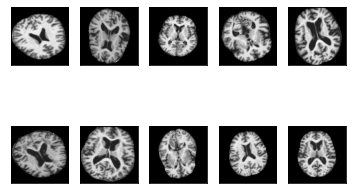

In [ ]:
#Print 10 imagenes with the augmentation of data 

for imagen, etiqueta in train_generator:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [ ]:
# Model Compile 
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
History = model.fit(train_generator,
                        validation_data=test_generator,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 1.3229 - auc: 0.7881 
Epoch 1: val_auc improved from -inf to 0.79584, saving model to ./best_weights.hdf5
41/41 [==============================] - 1086s 26s/step - loss: 1.3229 - auc: 0.7881 - val_loss: 2.3135 - val_auc: 0.7958
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 1.0672 - auc: 0.8302
Epoch 2: val_auc improved from 0.79584 to 0.79651, saving model to ./best_weights.hdf5
41/41 [==============================] - 93s 2s/step - loss: 1.0672 - auc: 0.8302 - val_loss: 1.5877 - val_auc: 0.7965
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.9807 - auc: 0.8437
Epoch 3: val_auc improved from 0.79651 to 0.84446, saving model to ./best_weights.hdf5
41/41 [==============================] - 93s 2s/step - loss: 0.9807 - auc: 0.8437 - val_loss: 0.9691 - val_auc: 0.8445
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.9087 - auc: 0.8583
Epoch 4: val_auc improved

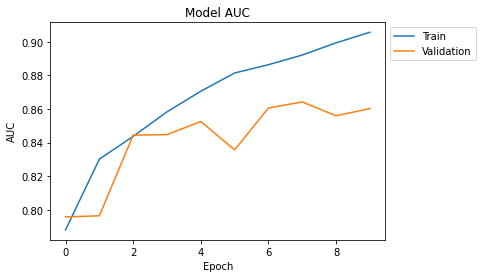

In [ ]:
# Summarize history for loss

plt.plot(History.history['auc'])
plt.plot(History.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


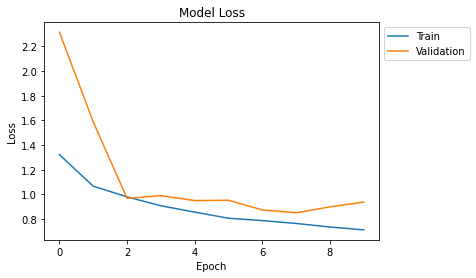

In [ ]:
# Summarize history for loss

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
#Save model
model.save('AlzheimerCNN.h5')

In [ ]:
!pip install tensorflowjs
#!pip install tensorflowjs 3.1.0 Python Libraries and Tools for TensorFlow.js

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras AlzheimerCNN.h5 carpeta_salida

In [ ]:
!zip -r ModelAlzheimer_CNN.zip /content/carpeta_salida/

updating: content/carpeta_salida/ (stored 0%)
  adding: content/carpeta_salida/group1-shard132of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard104of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard101of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard109of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard127of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard98of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard21of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard112of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard167of174.bin (deflated 6%)
  adding: content/carpeta_salida/group1-shard164of174.bin (deflated 6%)
  adding: content/carpeta_salida/group1-shard169of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard107of174.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard55of174.bin (deflated 7%)
  adding: content/car

In [ ]:
#Load mode
model = keras.models.load_model('/content/drive/MyDrive/Paper_V2/AlzheimerCNN.h5')

In [ ]:
#Funtion that take a image url and makes a prediction

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = model.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

<img src = 'https://img.medscapestatic.com/pi/meds/ckb/37/14937tn.jpg'> 


In [ ]:
#0 = Demencia Leve, 1 = Demencia Moderada, 2 = No demente, 3 = Demencia muy leve
url = 'https://img.medscapestatic.com/pi/meds/ckb/37/14937tn.jpg' 
prediccion = categorizar (url)
print(prediccion)

0


<img src = 'https://media.istockphoto.com/photos/brain-mri-scan-of-healthy-male-high-resolution-picture-id1172987259?k=20&m=1172987259&s=170667a&w=0&h=-36G1-d9LapKcVbn5clxbDsq6C0dxTLp6DiAEDpaekY='>

In [ ]:
#0 = Demencia Leve, 1 = Demencia Moderada, 2 = No demente, 3 = Demencia muy leve
url = 'https://media.istockphoto.com/photos/brain-mri-scan-of-healthy-male-high-resolution-picture-id1172987259?k=20&m=1172987259&s=170667a&w=0&h=-36G1-d9LapKcVbn5clxbDsq6C0dxTLp6DiAEDpaekY=' 
prediccion = categorizar (url)
print(prediccion)

2


<img src = 'https://www.cedars-sinai.org/content/dam/cedars-sinai/programs-and-services/imaging-center/for-patients/exams-by-procedure/ct-brain-contrast.jpg'>

In [ ]:
#0 = Demencia Leve, 1 = Demencia Moderada, 2 = No demente, 3 = Demencia muy leve
url = 'https://www.cedars-sinai.org/content/dam/cedars-sinai/programs-and-services/imaging-center/for-patients/exams-by-procedure/ct-brain-contrast.jpg' 
prediccion = categorizar (url)
print(prediccion)

2


In [ ]:
def prepare(filepath):
    IMAGE_CHANNEL = 3
    IMG_SIZE = 224
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

In [ ]:
val =  model.predict(prepare("/content/drive/MyDrive/Paper_V2/Alzheimer/test/ModerateDemented/31 (2).jpg"))
val2 = np.argmax(val[0], axis=-1)

print(val2)

0
